In [12]:
import torch
import pytorch_lightning as pl
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar, RichModelSummary

In [7]:
# Lorenz system
def lorenz63(t, X):
    u, v, w = X
    up = -10*(u - v)
    vp = 28*u - v - u*w
    wp = -2.667*w + u*v
    return up, vp, wp
# Simulation params
# max time, number of data points
tmax, n = 100, 1000  

In [8]:
class L63Dataset(Dataset):
    def __init__(self, df):
        self.x = torch.tensor(df.loc[:, ~df.columns.isin(['x', 'y', 'z'])].values,dtype=torch.float32)
        self.y = torch.tensor(df.loc[:, df.columns.isin(['x', 'y', 'z'])].values,dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [9]:
class MLP(pl.LightningModule):
    def __init__(self):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(15, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)

        self.lrelu = nn.LeakyReLU()

        self.loss = nn.MSELoss()

    def forward(self, input):
        # print("INPUT:", input.shape, type(input))
        x = self.lrelu(self.input_layer(input))
        x = self.lrelu(self.layer2(x))
        x = self.lrelu(self.layer3(x))
        output = self.output_layer(x)
        return output
    
    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.SGD(params=params, lr = 0.0008)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        input, target = batch
        outputs = self(input)
        loss = self.loss(outputs, target)
        values = {"loss": loss}  # add more items if needed
        self.log_dict(values)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input, target = batch
        outputs = self(input)
        loss = self.loss(outputs, target)
        values = {"val_loss": loss}  # add more items if needed
        self.log_dict(values)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        input, target = batch
        return self(input)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ input_layer  │ Linear    │  1.0 K │
│ 1 │ layer2       │ Linear    │  2.1 K │
│ 2 │ layer3       │ Linear    │  1.1 K │
│ 3 │ output_layer │ Linear    │     99 │
│ 4 │ lrelu        │ LeakyReLU │      0 │
│ 5 │ loss         │ MSELoss   │      0 │
└───┴──────────────┴───────────┴────────┘

Trainable params: 4.3 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 K                                                                                                
Total estimated model params size (MB): 0

Output()

c:\Users\murat\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_
connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\murat\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_
connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\murat\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595:
PossibleUserWarning: The number of training batches (16) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=150` reached.


Output()

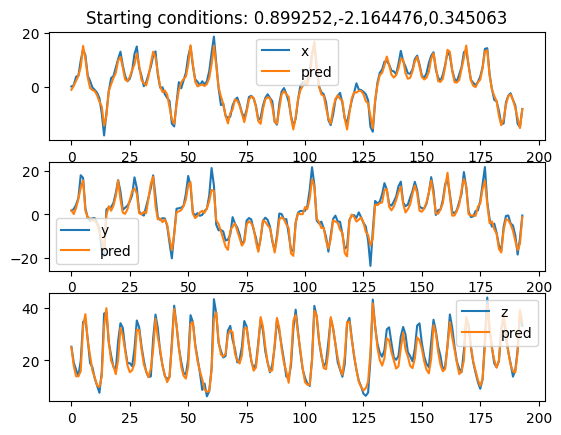

In [14]:
model = MLP()
checkpoint_callback = ModelCheckpoint()
rich_progress = RichProgressBar()
rich_summary = RichModelSummary()

trainer = pl.Trainer(max_epochs=150, callbacks=[checkpoint_callback, rich_progress, rich_summary])
# Generate random starting point
u0 = np.random.randn()
v0 = np.random.randn()
w0 = np.random.randn()

# Generate three different noise
xn = np.random.randn(n)
yn = np.random.randn(n)
zn = np.random.randn(n)

# Solve system
soln = solve_ivp(lorenz63, (0, tmax), (u0, v0, w0), dense_output=True)
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

x += xn
y += yn 
z += zn

# Prepare dataset
df = pd.DataFrame(np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], axis=1), columns=["x", "y", "z"])
for i in range(5):
    df[f"x_{i+1}"] = df.x.shift(i+1)
    df[f"y_{i+1}"] = df.y.shift(i+1)
    df[f"z_{i+1}"] = df.z.shift(i+1)
df.dropna(inplace=True)
traindata, validdata, testdata = df.iloc[0:500,:], df.iloc[501:800,:], df.iloc[801:,:]

traindataloader = DataLoader(L63Dataset(traindata), batch_size=32)
validdataloader = DataLoader(L63Dataset(validdata), batch_size=32)
testdataloader = DataLoader(L63Dataset(testdata))

trainer.fit(model, train_dataloaders=traindataloader, val_dataloaders=validdataloader)

predictions = trainer.predict(model, testdataloader)
predictions = pd.DataFrame(torch.cat(predictions).numpy(), columns=["xp", "yp", "zp"])

# Plot
fig, ax = plt.subplots(3, 1)
ax[0].set_title(f"Starting conditions: {np.round(u0, 6)},{np.round(v0, 6)},{np.round(w0, 6)}")
ax[0].plot(testdata.reset_index()['x'], label="x")
ax[0].plot(predictions['xp'], label="pred")
ax[0].legend()
ax[1].plot(testdata.reset_index()['y'], label="y")
ax[1].plot(predictions['yp'], label="pred")
ax[1].legend()
ax[2].plot(testdata.reset_index()['z'], label="z")
ax[2].plot(predictions['zp'], label="pred")
ax[2].legend()
plt.show()

Output()

c:\Users\murat\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


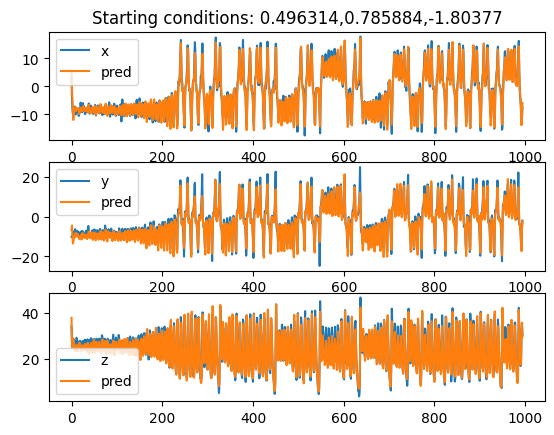

In [24]:
# Test unseen initial conditions
# Generate random starting point
u0 = np.random.randn()
v0 = np.random.randn()
w0 = np.random.randn()

# Generate three different noise
xn = np.random.randn(n)
yn = np.random.randn(n)
zn = np.random.randn(n)

# Solve system
soln = solve_ivp(lorenz63, (0, tmax), (u0, v0, w0), dense_output=True)
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

x += xn
y += yn 
z += zn

# Prepare dataset
df = pd.DataFrame(np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], axis=1), columns=["x", "y", "z"])
for i in range(5):
    df[f"x_{i+1}"] = df.x.shift(i+1)
    df[f"y_{i+1}"] = df.y.shift(i+1)
    df[f"z_{i+1}"] = df.z.shift(i+1)
df.dropna(inplace=True)

dataloader = DataLoader(L63Dataset(df), batch_size=32)

predictions = trainer.predict(model, dataloader)
predictions = pd.DataFrame(torch.cat(predictions).numpy(), columns=["xp", "yp", "zp"])

# Plot
fig, ax = plt.subplots(3, 1)
ax[0].set_title(f"Starting conditions: {np.round(u0, 6)},{np.round(v0, 6)},{np.round(w0, 6)}")
ax[0].plot(df.reset_index()['x'], label="x")
ax[0].plot(predictions['xp'], label="pred")
ax[0].legend()
ax[1].plot(df.reset_index()['y'], label="y")
ax[1].plot(predictions['yp'], label="pred")
ax[1].legend()
ax[2].plot(df.reset_index()['z'], label="z")
ax[2].plot(predictions['zp'], label="pred")
ax[2].legend()
plt.show()